In [1]:
!gdown https://drive.google.com/uc?id=1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai -O dataset

Downloading...
From: https://drive.google.com/uc?id=1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai
To: /content/dataset
100% 116M/116M [00:01<00:00, 98.6MB/s]


In [2]:
!unzip /content/dataset

Archive:  /content/dataset
   creating: PASCAL/
   creating: PASCAL/test/
   creating: PASCAL/test/Labels/
  inflating: PASCAL/test/Labels/2008_006240_label.mat  
  inflating: PASCAL/test/Labels/2008_006109_label.mat  
  inflating: PASCAL/test/Labels/2008_006879_label.mat  
  inflating: PASCAL/test/Labels/2008_006195_label.mat  
  inflating: PASCAL/test/Labels/2008_007595_label.mat  
  inflating: PASCAL/test/Labels/2008_006220_label.mat  
  inflating: PASCAL/test/Labels/2008_006382_label.mat  
  inflating: PASCAL/test/Labels/2008_006567_label.mat  
  inflating: PASCAL/test/Labels/2008_007325_label.mat  
  inflating: PASCAL/test/Labels/2008_006092_label.mat  
  inflating: PASCAL/test/Labels/2008_006517_label.mat  
  inflating: PASCAL/test/Labels/2008_006637_label.mat  
  inflating: PASCAL/test/Labels/2008_007145_label.mat  
  inflating: PASCAL/test/Labels/2008_006519_label.mat  
  inflating: PASCAL/test/Labels/2008_007195_label.mat  
  inflating: PASCAL/test/Labels/2008_006921_label.mat

In [3]:
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import math
import sys
import time
import torch
import os
from scipy.io import loadmat

from pascal_dataset import PASCALDataset
from engine import train_one_epoch, evaluate

import warnings

warnings.filterwarnings('ignore')

# **Model & Dataset**

In [4]:
# Load model
model = fasterrcnn_resnet50_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 86.8MB/s]


In [5]:
# Load dataset
train_dataset = PASCALDataset("/content/PASCAL/train")
test_dataset = PASCALDataset("/content/PASCAL/test")

In [6]:
# get number of classes
unique_labels = set()
for img_name in train_dataset.imgs:
    image_number = img_name.split('.')[0]
    label_path = os.path.join("/content/PASCAL/train", "Labels", image_number + '_label.mat')
    if os.path.exists(label_path):
        labels = loadmat(label_path)['labels'].flatten()
        unique_labels.update(labels)

In [7]:
len(unique_labels)

5

In [8]:
# modeify model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Number of classes in the dataset: N + 1 (N for your classes, +1 for the background)
num_classes = len(unique_labels) + 1


# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [9]:
from torch.utils.data.dataloader import default_collate
from utils import collate_fn

# Create train dataloader
train_dataLoader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


In [10]:
# Training stage
num_epochs = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
  logger = train_one_epoch(model, optimizer, train_dataLoader, device, epoch, 100)



Epoch: [0]  [  0/251]  eta: 0:36:50  lr: 0.000025  loss: 2.4796 (2.4796)  loss_classifier: 2.0749 (2.0749)  loss_box_reg: 0.3750 (0.3750)  loss_objectness: 0.0147 (0.0147)  loss_rpn_box_reg: 0.0151 (0.0151)  time: 8.8065  data: 0.0392  max mem: 4454
Epoch: [0]  [100/251]  eta: 0:03:24  lr: 0.002023  loss: 0.3573 (0.7001)  loss_classifier: 0.1104 (0.4082)  loss_box_reg: 0.2277 (0.2685)  loss_objectness: 0.0043 (0.0090)  loss_rpn_box_reg: 0.0113 (0.0145)  time: 1.3814  data: 0.0180  max mem: 7828
Epoch: [0]  [200/251]  eta: 0:01:08  lr: 0.004021  loss: 0.2180 (0.5117)  loss_classifier: 0.0726 (0.2581)  loss_box_reg: 0.1235 (0.2282)  loss_objectness: 0.0025 (0.0088)  loss_rpn_box_reg: 0.0147 (0.0165)  time: 1.3141  data: 0.0168  max mem: 7828
Epoch: [0]  [250/251]  eta: 0:00:01  lr: 0.005000  loss: 0.1873 (0.4667)  loss_classifier: 0.0608 (0.2249)  loss_box_reg: 0.1150 (0.2153)  loss_objectness: 0.0038 (0.0096)  loss_rpn_box_reg: 0.0137 (0.0169)  time: 1.3197  data: 0.0163  max mem: 7828


# **Evaluation**

In [11]:
# create test data loader

test_dataLoader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Evaluation

evaluate(model, test_dataLoader, device)

creating index...
index created!
Test:  [ 0/25]  eta: 0:00:39  model_time: 1.5405 (1.5405)  evaluator_time: 0.0086 (0.0086)  time: 1.5809  data: 0.0270  max mem: 8204
Test:  [24/25]  eta: 0:00:01  model_time: 1.3297 (1.3158)  evaluator_time: 0.0083 (0.0092)  time: 1.4031  data: 0.0313  max mem: 11639
Test: Total time: 0:00:34 (1.3615 s / it)
Averaged stats: model_time: 1.3297 (1.3158)  evaluator_time: 0.0083 (0.0092)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU

# **Inferencing**

In [69]:
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
from PIL import Image
from torchvision import transforms
from IPython.display import display
from torchvision.ops import nms
from scipy.io import loadmat

In [36]:
# load sample test data
image_path = '/content/PASCAL/test/Images/2008_006253.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([transforms.ToTensor()])

# Transform the image
image_tensor = transform(image)

# Add a batch dimension
image_tensor = image_tensor.unsqueeze(0).to(device)

model.eval()
model.to(device)
output = model(image_tensor)[0]

# NMS
selected_indices = nms(output['boxes'], output['scores'], iou_threshold=0.4)
selected_boxes = output['boxes'][selected_indices]
selected_labels = output['labels'][selected_indices]
selected_scores = output['scores'][selected_indices]

output = {
    'boxes':selected_boxes,
    'labels':selected_labels,
    'scores':selected_scores,
}


# convert data frim GPU to CPU
output = [{k: v.to(torch.device("cpu")) for k, v in output.items()}][0]

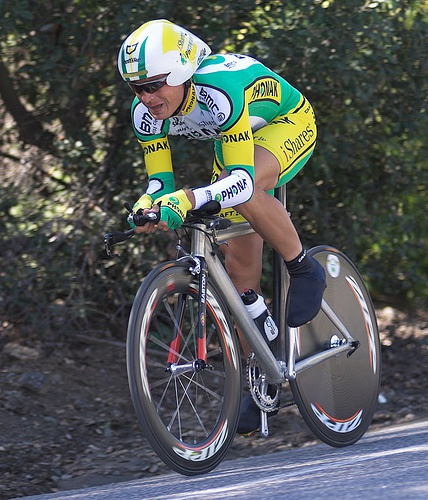

In [38]:
display(image)

In [39]:
class_names = {
    1: "person",
    2: "bicycle",
    3: "car",
    4: "motorbike",
    5: "airplane",
}

class_colors = {
    1: "green",
    2: "blue",
    3: "yellow",
    4: "red",
    5: "purpel",
}


In [54]:
# Ground Truth
label_path = '/content/PASCAL/test/Labels/2008_006253_label.mat'
bbox_path = '/content/PASCAL/test/BBox/2008_006253_bbox.mat'

boxes = loadmat(bbox_path)
boxes = boxes['bboxes']
labels = loadmat(label_path)['labels'].flatten()

ground_truth = {
    'boxes':boxes,
    'labels':labels,
}


In [66]:
image_1 = Image.open(image_path).convert('RGB')
draw = ImageDraw.Draw(image_1)
draw.text((10,10), "Expected Output", fill=(255,255,0))

# Draw bounding boxes and labels
for box, label in zip(ground_truth['boxes'], ground_truth['labels']):
    box = box
    label_name = class_names.get(label.item(), "N/A")
    color = class_colors.get(label.item(), "red")

    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=3)

counts = Counter(ground_truth['labels'])


x_position = image.width - 100
y_position = 10


font = ImageFont.load_default()

# Draw the class counts
for label, count in counts.items():
    label_name = class_names.get(label, "N/A")
    color = class_colors.get(label, "red")
    text = f"{label_name}: {count}"

    # Draw a filled rectangle behind the text
    text_width, text_height = draw.textsize(text, font=font)
    draw.rectangle([x_position, y_position, x_position + text_width, y_position + text_height], fill=color)

    # Draw the text
    draw.text((x_position, y_position), text, fill="white", font=font)

    y_position += text_height + 5


In [67]:
image_2 = Image.open(image_path).convert('RGB')
draw = ImageDraw.Draw(image_2)
draw.text((10,10), "Model Output", fill=(255,255,0))

# Draw bounding boxes and labels
for box, label in zip(output['boxes'], output['labels']):
    box = box.detach().numpy()
    label_name = class_names.get(label.item(), "N/A")
    color = class_colors.get(label.item(), "red")

    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=3)

counts = Counter(output['labels'].numpy())


x_position = image.width - 100
y_position = 10


font = ImageFont.load_default()

# Draw the class counts
for label, count in counts.items():
    label_name = class_names.get(label, "N/A")
    color = class_colors.get(label, "red")
    text = f"{label_name}: {count}"

    # Draw a filled rectangle behind the text
    text_width, text_height = draw.textsize(text, font=font)
    draw.rectangle([x_position, y_position, x_position + text_width, y_position + text_height], fill=color)

    # Draw the text
    draw.text((x_position, y_position), text, fill="white", font=font)

    y_position += text_height + 5


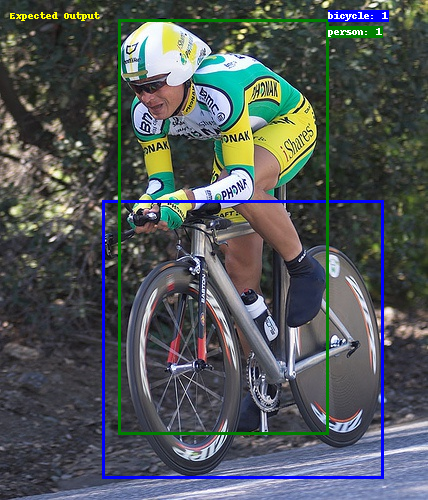

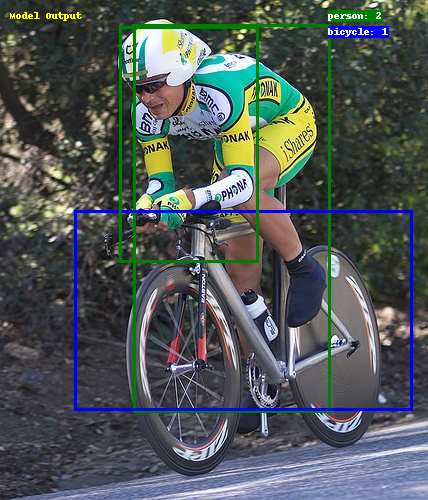

In [73]:
display(image_1, image_2)

In [ ]:
\